In [15]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from scipy import stats

In [20]:
%run data_pipeline.ipynb

########## Data pipeline ##########

Preparing CMU data
379 movies shared both name and release year, dropping
314 movies had actors with the same name, dropping

Merging Oscar dataset, after merge:
Number of different Oscar nominated movies in dataset: 952 in total 63968 different movies
Number of different Oscar nominated actors in dataset: 801 in total 134907 different actors
Number of Oscar nominated rows: 1443

Merging IMDb dataset, after merge:
Number of movies with ratings: 36758
Oscar nominated movies with rating: 939
Number of rows in data before cleaning:  443504
Number of rows in data after cleaning:  23819

FINAL STATE OF DATA
Number of rows:  23819
Number of different Oscar nominated movies in dataset: 394 in total 5989 different movies
Number of different Oscar nominated actors in dataset: 284 in total 2962 different actors
Number of Oscar nominated rows: 519
Processing done, dataset written to cache/data.csv


In [598]:
# Read data
df = pd.read_csv('cache/data.csv', sep=',', index_col=0)
unclean_df = pd.read_csv('cache/unclean_data.csv', sep=',', index_col=0)

In [600]:
df.head()

,title,box_office_revenue,runtime,languages,countries,genres,movie_identifier,actor_gender,actor_height,actor_ethnicity,actor_age,parsed_actor_name,actor_identifier,identifier,category,winner,oscar_nominated,year,average_rating,number_of_votes
0,Ghosts of Mars,14010832,98,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",ghosts of mars_2001,M,1.727,/m/0x67,32,ice cube,/m/01vw26l,ghosts of mars_2001_ice cube,NaN,NaN,False,2001,4.9,58876
4,Ghosts of Mars,14010832,98,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",ghosts of mars_2001,F,1.780,/m/044038p,27,natasha henstridge,/m/0346l4,ghosts of mars_2001_natasha henstridge,NaN,NaN,False,2001,4.9,58876
11,Ghosts of Mars,14010832,98,['English Language'],['United States of America'],"['Thriller', 'Science Fiction', 'Horror', 'Adv...",ghosts of mars_2001,F,1.727,/m/0x67,52,pam grier,/m/0418ft,ghosts of mars_2001_pam grier,NaN,NaN,False,2001,4.9,58876
51,Alexander's Ragtime Band,3600000,106,['English Language'],['United States of America'],"['Musical', 'Comedy']",alexanders ragtime band_1938,M,1.820,/m/06v41q,24,tyrone power,/m/02s58t,alexanders ragtime band_1938_tyrone power,NaN,NaN,False,1938,6.8,2357
52,Alexander's Ragtime Band,3600000,106,['English Language'],['United States of America'],"['Musical', 'Comedy']",alexanders ragtime band_1938,F,1.650,/m/033tf_,23,alice faye,/m/032xfz,alexanders ragtime band_1938_alice faye,NaN,NaN,False,1938,6.8,2357


## **Actor Network Analysis**

In [ ]:
import networkx as nx
from itertools import combinations

In [367]:
oscar_nominated = df[df['oscar_nominated']==True]

df_new_movies = df


In [363]:
print(len(df_new_movies), len(df))

478 23819


In [384]:
G = nx.Graph()

for _, row in df_new_movies.iterrows():
    G.add_node(row['actor_identifier'], oscar_nominated=row['oscar_nominated'])


for movie, group in df_new_movies.groupby('title'):
    actors = group['actor_identifier'].tolist()
    for actor1, actor2 in combinations(actors, 2):
        if G.has_edge(actor1, actor2):
            G[actor1][actor2]['movies'].append(movie)
        else:
            G.add_edge(actor1, actor2, movies=[movie])

colors = {True: 'gold', False: 'blue'}
node_colors = [colors[G.nodes[node]['oscar_nominated']] for node in G.nodes]


In [386]:
average_nominated_degree = []
average_not_nominated = []
degree_dict = dict(G.degree())
for node, degree in degree_dict.items():
    nominated = G.nodes[node]['oscar_nominated']
    if nominated: 
        average_nominated_degree.append(G.degree(node))
    else: 
        average_not_nominated.append(G.degree(node))

print(np.mean(average_not_nominated))
print(np.mean(average_nominated_degree))

37.05697714090754
63.29032258064516


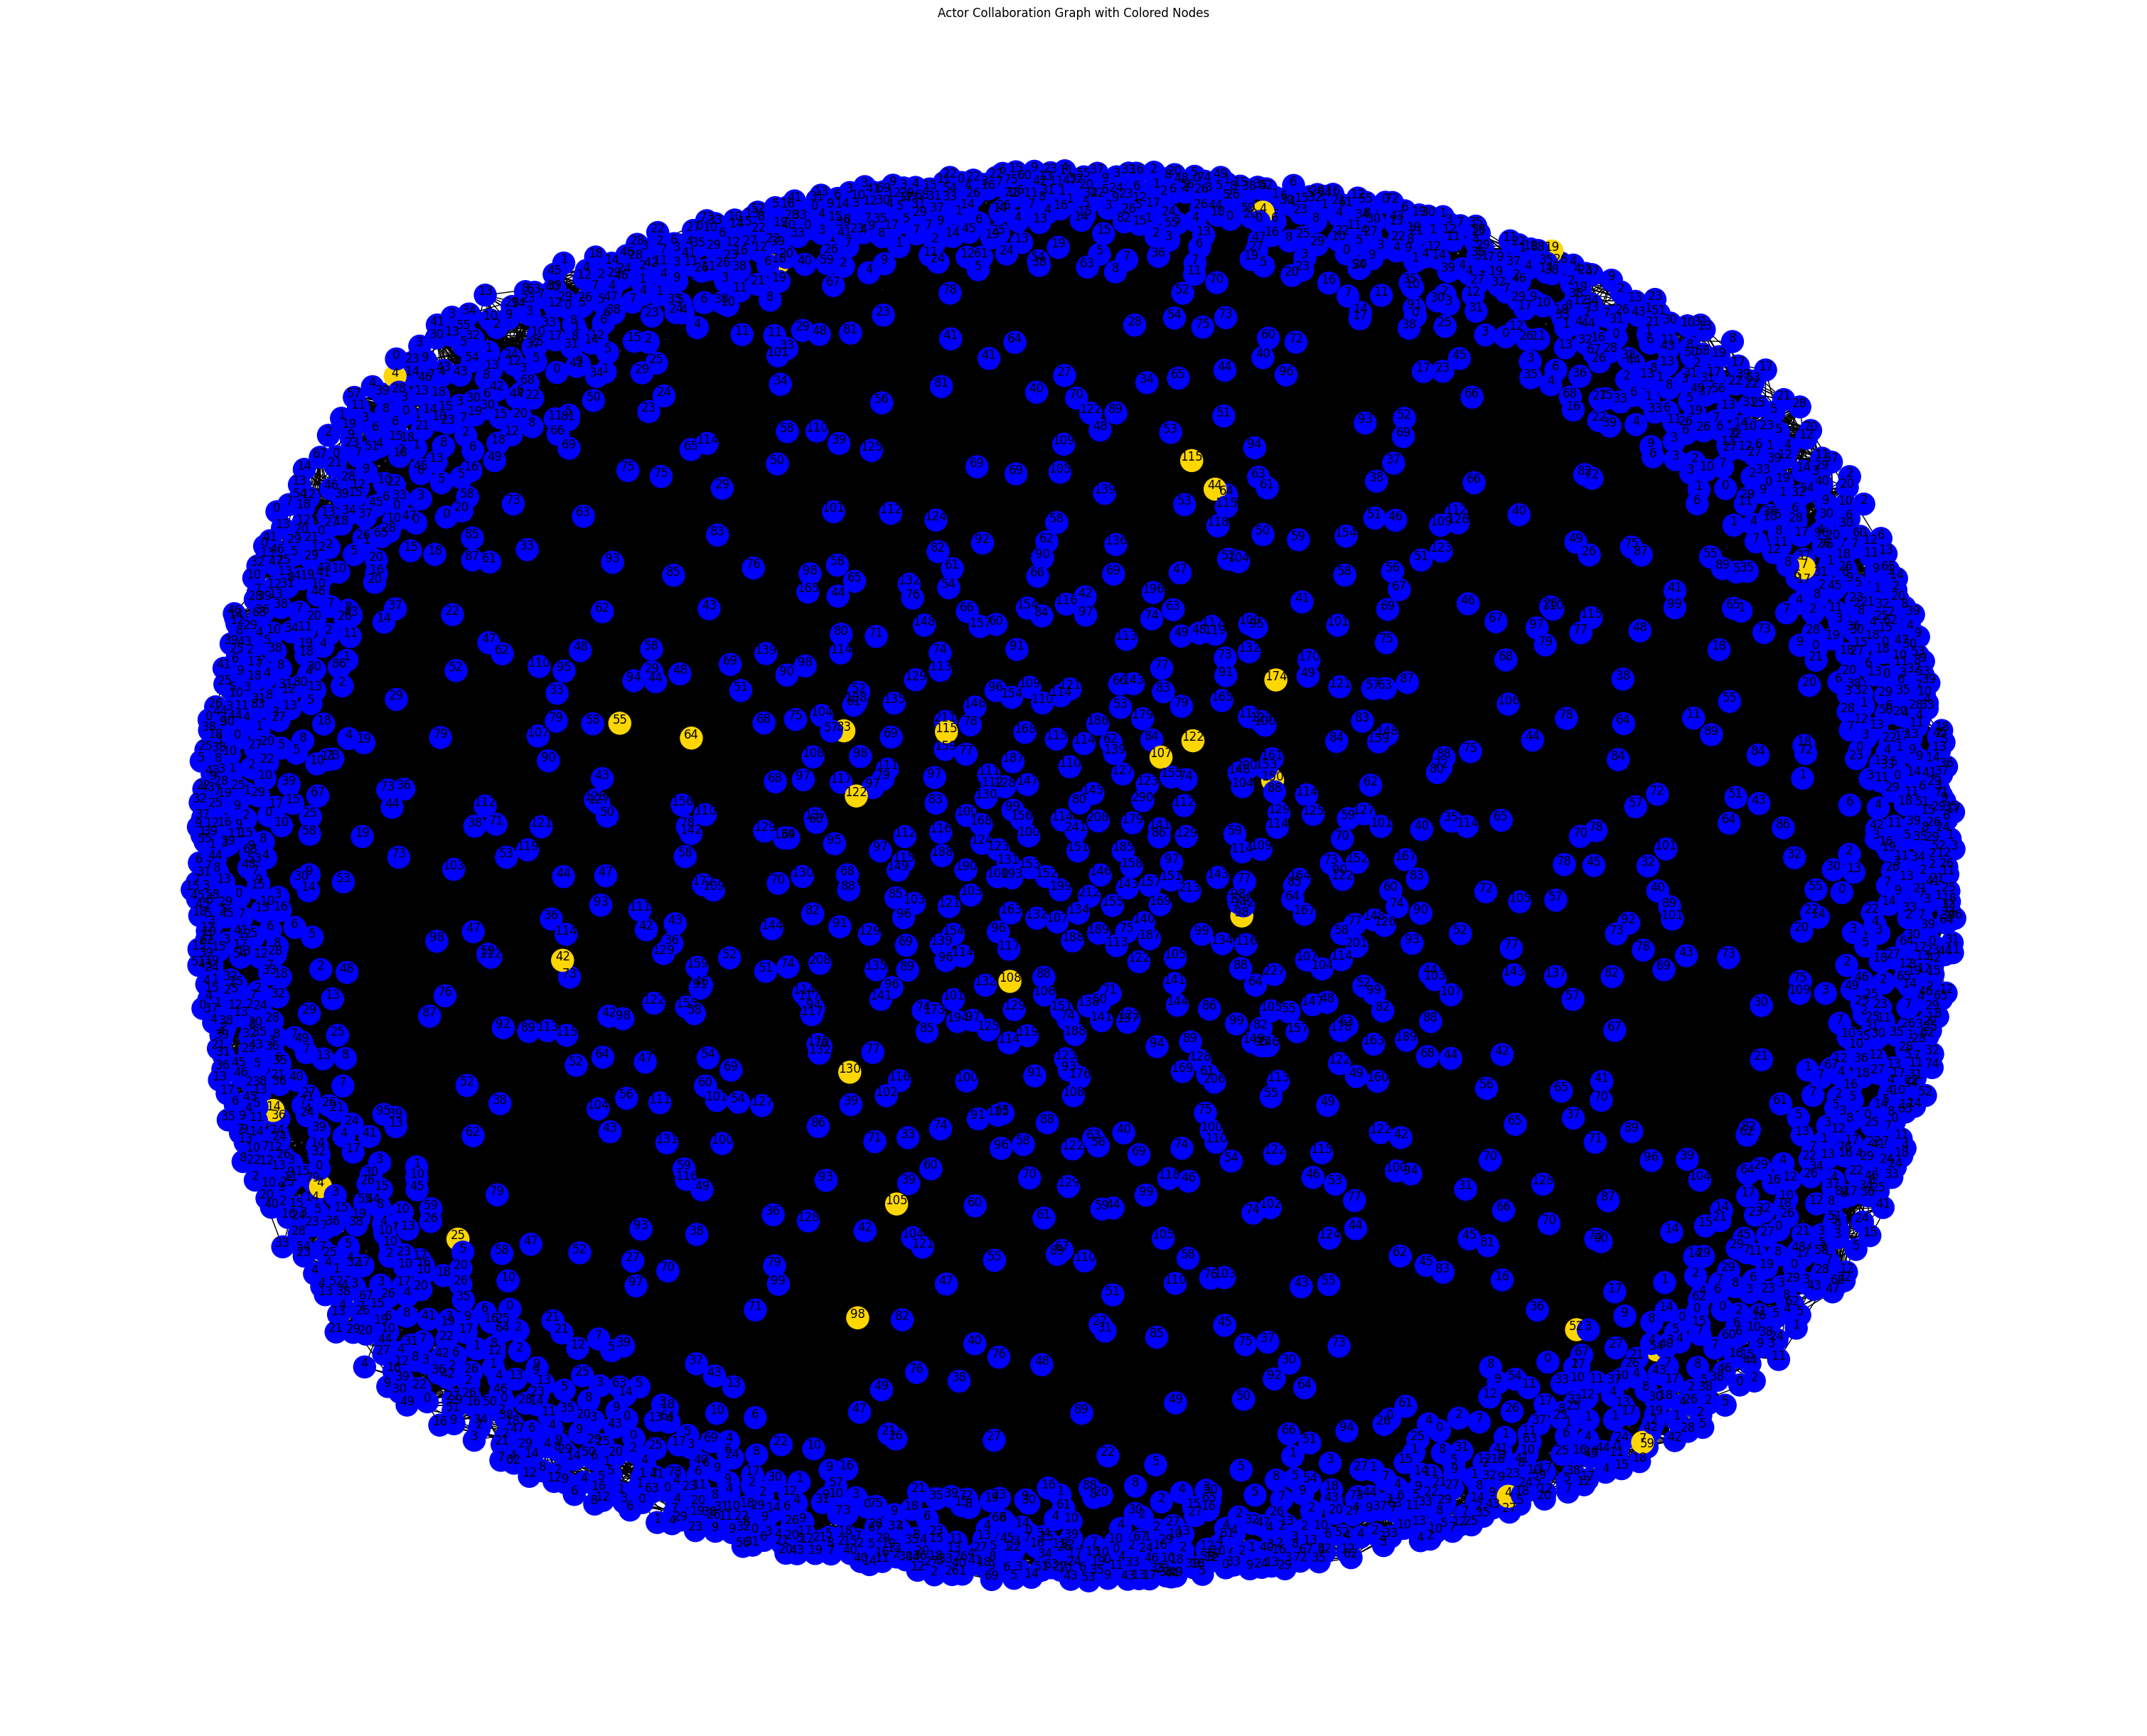

In [387]:
plt.figure(figsize=(30, 24))  
pos = nx.spring_layout(G, k=1, iterations=50)  
nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=500, font_size=5, font_weight="bold")
degree_dict = dict(G.degree())
for node, degree in degree_dict.items():
    plt.text(pos[node][0], pos[node][1], str(degree), fontsize=12, ha='center', color='black')
    

plt.title("Actor Collaboration Graph with Colored Nodes")
plt.show()

In [393]:
G = nx.Graph()
for movie, group in oscar_nominated.groupby('title'):
    actors = group['actor_identifier'].tolist()
    for actor1, actor2 in combinations(actors, 2):
        if G.has_edge(actor1, actor2):
            G[actor1][actor2]['movies'].append(movie)
        else:
            G.add_edge(actor1, actor2, movies=[movie])

Text(0.5, 1.0, 'Oscar Nominated Actors')

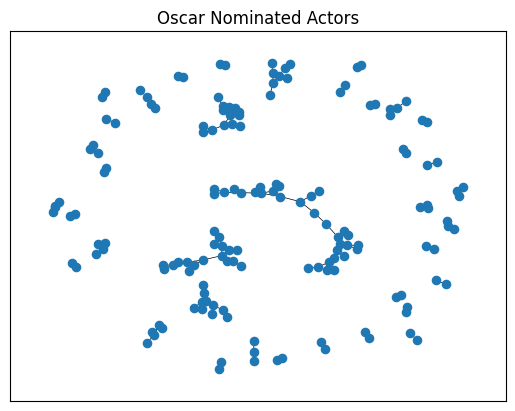

In [398]:
#pos = nx.spring_layout(G, k=1, iterations=50) 
nx.draw_networkx(G, pos=None, arrows=None, with_labels=False, node_size=35, width=0.5)
plt.title('Oscar Nominated Actors')

## **Year bias**

In [272]:
from scipy.interpolate import CubicSpline

Constructing df for analysis

In [319]:
# Counting movie releases per year
movie_df = df.drop_duplicates(subset='movie_identifier', keep='first', inplace=False)[['movie_identifier', 'year']]
movie_releases = movie_df.groupby('year').size().reset_index(name='count')
movie_releases.head()

,year,count
0,1928,1
1,1929,1
2,1930,1
3,1932,3
4,1933,5


In [315]:
# Counting oscar nominations per year
oscar_nominations = oscar_nominated.groupby('year').size().reset_index(name='count')
years = pd.DataFrame({'year': movie_releases['year'].unique()})
oscar_nominations = years.merge(oscar_nominations, on='year', how='left').fillna(0)
oscar_nominations.head()

,year,count
0,1928,0.0
1,1929,0.0
2,1930,0.0
3,1932,0.0
4,1933,0.0


In [314]:
# Counting nominated movies per year
nominations_per_movie_per_year = oscar_nominated.groupby(['year', 'movie_identifier']).agg({'title':'count'}).reset_index().rename(columns={'title':'count'})
unique_nominated_movies_per_year = nominations_per_movie_per_year.groupby(['year']).agg({'movie_identifier':'count'}).reset_index().rename(columns={'movie_identifier':'count'})
unique_nominated_movies_per_year.head()

,year,count
0,1934,1
1,1936,1
2,1939,3
3,1940,1
4,1941,1


In [316]:
# Merging releases and nominated movies per year
movie_releases_with_nominations = movie_releases.merge(unique_nominated_movies_per_year, on='year', how='left').fillna(0).rename(columns={'count_x' : 'releases', 'count_y':'nominated movies'})
movie_releases_with_nominations.head()

,year,releases,nominated movies
0,1928,1,0.0
1,1929,1,0.0
2,1930,1,0.0
3,1932,3,0.0
4,1933,5,0.0


In [317]:
# Merging in nr. of oscar nominations per year
releases_nominations_counts_df = movie_releases_with_nominations.merge(oscar_nominations, on='year', how='left').fillna(0).rename(columns={'count' : 'oscar nominations'})
releases_nominations_counts_df.head()

,year,releases,nominated movies,oscar nominations
0,1928,1,0.0,0.0
1,1929,1,0.0,0.0
2,1930,1,0.0,0.0
3,1932,3,0.0,0.0
4,1933,5,0.0,0.0


In [318]:
# Calculating % of movies that was nominated each year
releases_nominations_counts_df['%nominated'] = releases_nominations_counts_df['nominated movies'] / releases_nominations_counts_df['releases']
releases_nominations_counts_df.head()

,year,releases,nominated movies,oscar nominations,%nominated
0,1928,1,0.0,0.0,0.0
1,1929,1,0.0,0.0,0.0
2,1930,1,0.0,0.0,0.0
3,1932,3,0.0,0.0,0.0
4,1933,5,0.0,0.0,0.0


**Plotting**

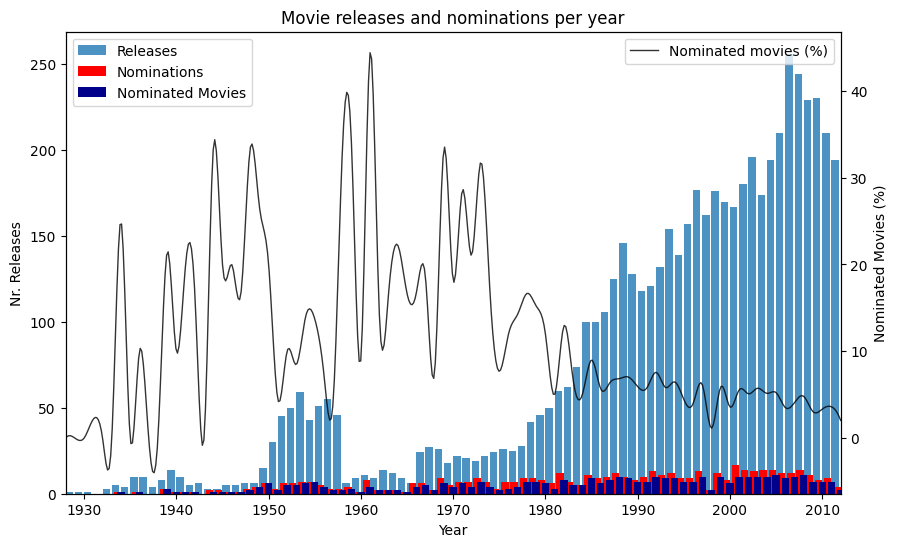

In [783]:
plt.figure(figsize=(10, 6))

plt.bar(releases_nominations_counts_df['year']+0.4, releases_nominations_counts_df['releases'], label ='Releases', alpha=0.8)
plt.bar(releases_nominations_counts_df['year']-0.4, releases_nominations_counts_df['oscar nominations'], label ='Nominations', color='red')
plt.bar(releases_nominations_counts_df['year'], releases_nominations_counts_df['nominated movies'], label ='Nominated Movies', color='#00008B')


plt.xlabel('Year')
plt.xlim(min(df['year']), max(df['year']))

plt.ylabel('Nr. Releases')

plt.legend()

plt.title('Movie releases and nominations per year')


x = releases_nominations_counts_df['year']
y = releases_nominations_counts_df['%nominated']

cs = CubicSpline(x, y)

x_smooth = np.linspace(min(x), max(x), 500)
y_smooth = cs(x_smooth)
ax2 = plt.twinx()
ax2.set_ylabel('Share')
ax2.plot(x_smooth, 100*y_smooth, color='black', label='Nominated movies (%)', alpha=0.8, linewidth=1)

ax2.set_ylabel('Nominated Movies (%)')
plt.legend()
plt.show()


## Genre

In [769]:
genre_df = df.copy()

In [770]:
genre_df['genres'] = genre_df['genres'].fillna('[]')
genre_lists = genre_df['genres'].apply(lambda x: x[1:-1].split(', ') if x != '[]' else [])
genre_lists = genre_lists.apply(lambda x: [g[1:-1] for g in x])
genre_lists = genre_lists.apply(lambda x: [g for g in x if g != ''] )
all_genres = set([genre for sublist in genre_lists for genre in sublist])

In [771]:
genre_dict = {}
for g in all_genres:
    genre_dict[g] = []

for list in genre_lists:  
    for g in all_genres:
        if g in list: 
            genre_dict[g].append(1)
        else: genre_dict[g].append(0)

In [772]:
genre_df = pd.concat([genre_df.reset_index(drop=True), pd.DataFrame(genre_dict).reset_index(drop=True)], axis=1)
#genre_df = genre_df.drop(columns='index') 

In [773]:
genre_df_oscar_nominated = genre_df[genre_df['oscar_nominated'] == True]

In [774]:
genre_df_oscar_nominated.columns.shape

(280,)

In [775]:
genre_frequencies = genre_df.iloc[:,20:].sum(axis=0).sort_values(ascending=False)

In [820]:
nominated_genre_frequencies = genre_df_oscar_nominated.iloc[:,20:].sum(axis=0)
nominated_genre_frequencies = nominated_genre_frequencies.reindex(genre_frequencies.index)

In [821]:
assert nominated_genre_frequencies.index.all() == genre_frequencies.index.all()

In [831]:
nominated_genre_frequencies_normalized = (nominated_genre_frequencies - nominated_genre_frequencies.mean())/nominated_genre_frequencies.std()
nominated_genre_frequencies_normalized = nominated_genre_frequencies_normalized + abs(min(nominated_genre_frequencies_normalized))
nominated_genre_frequencies_normalized = (nominated_genre_frequencies_normalized - min(nominated_genre_frequencies_normalized))/(max(nominated_genre_frequencies_normalized)- min(nominated_genre_frequencies_normalized))



genre_frequencies_normalized = (genre_frequencies - genre_frequencies.mean())/genre_frequencies.std()
genre_frequencies_normalized = genre_frequencies_normalized + abs(min(genre_frequencies_normalized))
genre_frequencies_normalized = (genre_frequencies_normalized - min(genre_frequencies_normalized))/(max(genre_frequencies_normalized)- min(genre_frequencies_normalized))


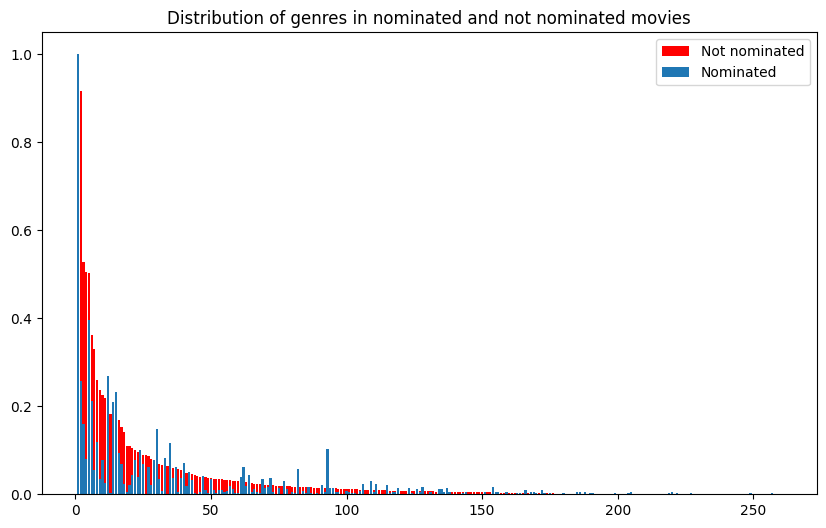

In [832]:
plt.figure(figsize=(10, 6))
plt.bar(np.arange(1, len(genre_frequencies)+1), genre_frequencies_normalized, color='red', label='Not nominated')
plt.bar(np.arange(1, len(genre_frequencies)+1), nominated_genre_frequencies_normalized, label='Nominated')
plt.title('Distribution of genres in nominated and not nominated movies')
plt.legend()

In [833]:
import scipy
scipy.stats.kstest(nominated_genre_frequencies_normalized, genre_frequencies_normalized)

KstestResult(statistic=np.float64(0.4230769230769231), pvalue=np.float64(3.0311703148734133e-21), statistic_location=np.float64(0.0), statistic_sign=np.int8(1))

We can reject null hypothesis